# Introdução ao Caderno

Esse caderno trata da predição de óbitos humanos por febre amarela no Brasil por aprendizado de máquinas supervisionado, a partir de uma base de dados pública disponibilizada pelo Mistério da Saúde do Brasil. 

* A fonte dos dados pode ser encontrada no seguinte endereço: 

    https://dados.gov.br/dados/conjuntos-dados/febre-amarela-em-humanos-e-primatas-no-humanos---1994-a-2021

* Os dados são rótulados e possuem as seguintes variáveis:

    - MACRORREG_LPI: Identificador sequencial único
    - COD_UF_LPI Sigla da macrorregião do local provável de infecção
    - UF_LPI: Código IBGE da Unidade Federada do local provável de infecção
    - COD_MUN_LPI: Sigla da Unidade Federada do local provável de infecção
    - MUN_LPI: Nome do município do local provável de infecção
    - SEXO: Sexo do indivíduo
    - IDADE: Idade do indivíduo
    - DT_IS: Data de início dos sintomas do indivíduo (dd/mm/aaaa)
    - SE_IS: Semana epidemiológica de início dos sintomas do indivíduo
    - MES_IS: Mês de início dos sintomas do indivíduo
    - ANO_IS: Ano de início dos sintomas do indivíduo
    - MONITORAMENTO_IS: Período de monitoramento de início dos sintomas do indivíduo*
    - OBITO: Evolução para o óbito

### Carregando dados

In [1]:
import pandas as pd

df = pd.read_csv('datas/fa_casoshumanos_1994-2021.csv', sep=';')

df_final = df.copy()

df = df.drop('ID', axis=1)

df.head(3)

,MACRORREG_LPI,COD_UF_LPI,UF_LPI,COD_MUN_LPI,MUN_LPI,SEXO,IDADE,DT_IS,SE_IS,MES_IS,ANO_IS,MONITORAMENTO_IS,OBITO
0,N,14,RR,140005.0,Alto Alegre,M,NaN,29/11/1994,48.0,11.0,1994,1994/1995,SIM
1,N,14,RR,140045.0,Pacaraima,M,19,19/02/1995,8.0,2.0,1995,1994/1995,NÃO
2,NE,21,MA,210060.0,Amarante do Maranhão,M,32,01/04/1995,13.0,4.0,1995,1994/1995,IGN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2758 entries, 0 to 2757
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MACRORREG_LPI     2758 non-null   object 
 1   COD_UF_LPI        2758 non-null   int64  
 2   UF_LPI            2758 non-null   object 
 3   COD_MUN_LPI       2751 non-null   float64
 4   MUN_LPI           2752 non-null   object 
 5   SEXO              2757 non-null   object 
 6   IDADE             2756 non-null   object 
 7   DT_IS             2753 non-null   object 
 8   SE_IS             2742 non-null   float64
 9   MES_IS            2747 non-null   float64
 10  ANO_IS            2758 non-null   int64  
 11  MONITORAMENTO_IS  2758 non-null   object 
 12  OBITO             2758 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 280.2+ KB


# Funções para Tratamento de Dados

### Taxa de ocorrência de Valores

In [3]:
def t_ocorrencia(coluna):

    # Valores onde há ocorrência
    valores = list(coluna.value_counts().index)
    
    # Quantidade de ocorrências por região
    ocorrencia = list(coluna.value_counts())
    
    # Quantidade total de ocorrências adaptado à porcentagem
    n = sum(ocorrencia) * 100**(-1)
    
    for i in range(len(valores)):
        if i < 10:
            print(f'- A variável {valores[i]} representa {ocorrencia[i]/n:.2f}% do total.')

        elif i == 10:
            print('[...]')

        else:
            pass       

### Numeralização por Binários

Consiste na transformação das variáveis qualitativas em binário.

In [4]:
# Função

def coluna_letras_para_binario(dataframe, coluna):
    
    # Cria variáveis dummy para a coluna especificada
    dummies = pd.get_dummies(dataframe[coluna], prefix=coluna, drop_first=True).astype(int)
    
    # Adiciona as variáveis dummy ao DataFrame original
    dataframe = pd.concat([dataframe, dummies], axis=1)
    
    # Remove a coluna original
    dataframe.drop(coluna, axis=1, inplace=True)
    
    return dataframe

### Numeralização por Percentual

Consiste na transformação das variáveis qualitativas em seu percentual de aparição.

In [5]:
def coluna_letras_para_numeros(dataframe, coluna):
    
    # Calcular a frequência relativa de cada categoria
    frequencia_relativa = dataframe[coluna].value_counts(normalize=True).to_dict()
    
    # Substituir os valores categóricos pelos valores numéricos correspondentes
    dataframe[coluna] = dataframe[coluna].map(frequencia_relativa)
    
    return dataframe

### Substituição de nulos por mediana

Consiste na substituição dos valores nulos de uma coluna por sua mediana.

In [6]:
def substituir_nulos_por_mediana_coluna(dataframe, coluna):

    # Calcula a mediana da coluna
    mediana_coluna = dataframe[coluna].median()
    
    # Substitui os valores nulos pela mediana da coluna usando loc
    dataframe.loc[dataframe[coluna].isnull(), coluna] = mediana_coluna
    
    return dataframe

### Substituição de nulos por média

Consiste na substituição dos valores nulos de uma coluna por sua média.

In [7]:
def substituir_nulos_por_media_coluna(dataframe, coluna):

    # Calcula a media da coluna
    media_coluna = dataframe[coluna].mean()
    
    # Substitui os valores nulos pela mediana da coluna usando loc
    dataframe.loc[dataframe[coluna].isnull(), coluna] = media_coluna
    
    return dataframe

## K-Means

In [8]:
from sklearn.cluster import KMeans

def c_kmeans(k, df):

    km = KMeans(n_clusters=k,
            init='k-means++',
            max_iter=300,
            n_init=10,
            random_state=0)
    
    km.fit(df)

    return km

# Processamento de Colunas

### 'MACRORREG_LPI'

Como dito no início do caderno, apenas a predição para a região sudeste será feita. Os motivos serão explicados a seguir, em uma análise de ocorrência por região.

In [9]:
# Regiões onde há ocorrência
t_ocorrencia(df['MACRORREG_LPI'])

- A variável SE representa 85.21% do total.
- A variável N representa 6.78% do total.
- A variável CO representa 5.33% do total.
- A variável S representa 2.25% do total.
- A variável NE representa 0.44% do total.


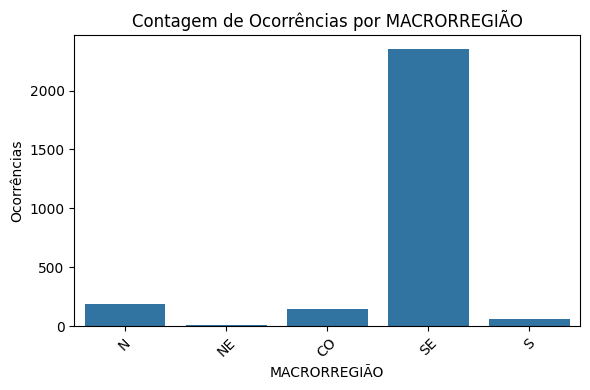

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='MACRORREG_LPI', data=df)
plt.xlabel('MACRORREGIÃO')
plt.ylabel('Ocorrências')
plt.title('Contagem de Ocorrências por MACRORREGIÃO')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ao analisar a representatividade das regiões nos dados, nota-se a imensa disparidade da região sudeste com as outras. Dado que a soma das outras regiões representa menos de 15% das ocorrências, elas serão unidas em uma só. Após isso os dados da coluna serão transformados em binário visto que a coluna é qualitativa, e possuem poucos dados diferentes.

In [11]:
# Transformando regiões diferentes da sudeste em R que representa Restante
df.loc[df['MACRORREG_LPI'] != 'SE', 'MACRORREG_LPI'] = 'R'

# Transformando variáveis da coluna em binário
df = coluna_letras_para_binario(df, 'MACRORREG_LPI')

df['MACRORREG_LPI_SE'].value_counts()

MACRORREG_LPI_SE
1    2350
0     408
Name: count, dtype: int64

### 'COD_UF_LPI' e 'UF_LPI'

As duas colunas representam a mesma coisa, visto que uma representa o ddd único de cada estado, e outra representa a sigla de cada estado. Como a coluna 'UF_LPI' possui siglas mais facilmente visualizaǘeis, ela será mantida.

In [12]:
# Excluindo coluna 'UF_LPI'
df = df.drop('COD_UF_LPI', axis=1)

Por ilação lógica, se a região sudeste representa a esmagadora maioria das ocorrências, então suas microrregiões representadas pelo ddd também lideram as ocorrências, provocando uma provavel baixa representatividade das outras microrregiões. Logo, seguindo a mesma linha de pensamento das transformações anteriores, as microrregiões que possuírem baixo recorrência estatística serão unidas em uma só.

In [13]:
# Microrregiões onde há ocorrência
t_ocorrencia(df['UF_LPI'])

- A variável MG representa 39.81% do total.
- A variável SP representa 24.91% do total.
- A variável RJ representa 11.13% do total.
- A variável ES representa 9.35% do total.
- A variável GO representa 3.55% do total.
- A variável PA representa 3.44% do total.
- A variável AM representa 1.74% do total.
- A variável SC representa 0.98% do total.
- A variável MT representa 0.98% do total.
- A variável TO representa 0.83% do total.
[...]


De forma a resumir a quantidade de microrregiões sem representatividade, as que possuírem menos de 4% de ocorrência (que curiosamente são as microrregiões que não pertencem a região sudeste) serão transformadas em apenas uma variável. Após isso elas serão transformadas em variáveis numéricas de acordo com seu percentual de ocorrência.

In [14]:
# Transformando microrregiões sem representatividade em R que representa Restante
df.loc[~df['UF_LPI'].isin(['MG', 'SP', 'RJ', 'ES']), 'UF_LPI'] = 'R'

# Transformando variáveis da coluna em percentual de ocorrência
df = coluna_letras_para_numeros(df, 'UF_LPI')

df['UF_LPI'].value_counts()

UF_LPI
0.398115    1098
0.249094     687
0.147933     408
0.111313     307
0.093546     258
Name: count, dtype: int64

### 'COD_MUN_LPI' e 'MUN_LPI'

Assim como no caso das microrregiões com os ddd's, as colunas 'COD_MUN_LPI' e 'MUN_LPI' representam a mesma coisa, logo, a coluna A 'COD_MUN_LPI' será excluída, e a 'MUN_LPI' tratada.

In [15]:
# Excluindo coluna 'UF_LPI'
df = df.drop('COD_MUN_LPI', axis=1)

A coluna possui valores alguns poucos nulos. Para atribuir o valor dessas colunas, será atribuída a cidade com maior ocorrência para a UF que representa a cidade. Isso pois valores centrais como a média ou mediana não fazem sentido, visto que a coluna possui valores qualitativos e um número alto de cidades diferentes.

In [16]:
# Checando valores nulos
df[df['MUN_LPI'].isnull()]

,UF_LPI,MUN_LPI,SEXO,IDADE,DT_IS,SE_IS,MES_IS,ANO_IS,MONITORAMENTO_IS,OBITO,MACRORREG_LPI_SE
1103,0.398115,NaN,M,17,02/03/2017,9.0,3.0,2017,2016/2017,IGN,1
1202,0.398115,NaN,F,73,30/04/2017,18.0,4.0,2017,2016/2017,IGN,1
1217,0.398115,NaN,M,52,01/05/2017,18.0,5.0,2017,2016/2017,SIM,1
1241,0.398115,NaN,M,35,16/01/2017,3.0,1.0,2017,2016/2017,IGN,1
1243,0.398115,NaN,M,21,12/06/2017,24.0,6.0,2017,2016/2017,IGN,1
2642,0.249094,NaN,M,27,31/12/2018,1.0,12.0,2018,2018/2019,NÃO,1


Os dois valores de 'UF_LPI' que possuem dados nulos são '0.398115' e '0.249094'. Logo, serão escolhidas as cidades com mais ocorrência dessas regiões.

In [17]:
# Lista de valores únicos do 'UF_LPI'
df['UF_LPI'].unique()

array([0.14793328, 0.24909355, 0.39811458, 0.09354605, 0.11131255])

In [18]:
# Ocorrências de 0.24909355
t_ocorrencia(df[df['UF_LPI'] == df['UF_LPI'].unique()[1]]['MUN_LPI'])

- A variável MAIRIPORÃ representa 24.34% do total.
- A variável ATIBAIA representa 7.29% do total.
- A variável SÃO PAULO representa 4.81% do total.
- A variável NAZARÉ PAULISTA representa 4.66% do total.
- A variável GUARULHOS representa 4.08% do total.
- A variável IPORANGA representa 2.77% do total.
- A variável ELDORADO representa 2.33% do total.
- A variável IBIÚNA representa 2.04% do total.
- A variável PIRAJU representa 2.04% do total.
- A variável SANTA ISABEL representa 1.75% do total.
[...]


In [19]:
# Ocorrências de 0.0.39811458
t_ocorrencia(df[df['UF_LPI'] == df['UF_LPI'].unique()[2]]['MUN_LPI'])

- A variável LADAINHA representa 4.21% do total.
- A variável JUIZ DE FORA representa 3.75% do total.
- A variável MARIANA representa 3.75% do total.
- A variável NOVA LIMA representa 3.29% do total.
- A variável POTÉ representa 2.38% do total.
- A variável SERRO representa 2.29% do total.
- A variável BARÃO DE COCAIS representa 2.20% do total.
- A variável SABINÓPOLIS representa 2.10% do total.
- A variável NOVO CRUZEIRO representa 1.92% do total.
- A variável TEÓFILO OTONI representa 1.74% do total.
[...]


In [20]:
# Transformando valores nulos em cidades com mais ocorrências para cada macrorregião
df.loc[(df['MUN_LPI'].isnull()) & (df['UF_LPI'] == df['UF_LPI'].unique()[1]), 'MUN_LPI'] = str('MAIRIPORÃ')
df.loc[(df['MUN_LPI'].isnull()) & (df['UF_LPI'] == df['UF_LPI'].unique()[2]), 'MUN_LPI'] = str('LADAINHA')

# Transformando variáveis da coluna em percentual de ocorrência
df = coluna_letras_para_numeros(df, 'MUN_LPI')

print('Valores nulos:', sum(df['MUN_LPI'].isnull()))

Valores nulos: 0


### SEXO

A coluna sexo possui apenas duas variáveis. Logo, o único procedimento a se tomar é transformar a coluna em numérico binário.

In [21]:
# Transformação em binário
df = coluna_letras_para_binario(df, 'SEXO')

df['SEXO_M'].value_counts()

SEXO_M
1    2281
0     477
Name: count, dtype: int64

### IDADE

A coluna 'IDADE' é quantitativa, e o único problema que ela apresenta são seus valores nulos.

In [22]:
# Remover vírgulas e converter para float
df['IDADE'] = df['IDADE'].str.replace(',', '.').astype(float)

print(f"Existem {len(df['IDADE'].value_counts())} variáveis diferentes e {df['IDADE'].isnull().sum()} valores nulos.")

Existem 193 variáveis diferentes e 2 valores nulos.


Dado a existência de uma grande quantidade de variáveis, faz mais sentido preencher os valores nulos com medidas centrais.

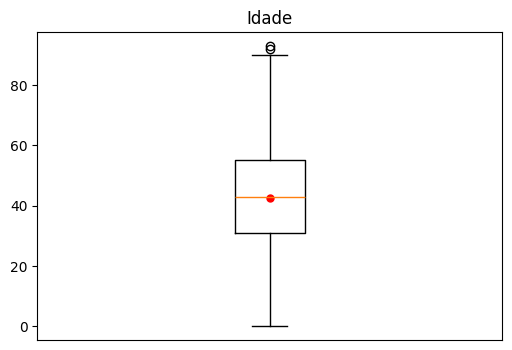

In [23]:
#Excluindo nulos em DataFrame teste para analisar boxplot
df_boxplot = df.dropna(subset=['IDADE'])

# Plotando o gráfico boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(df_boxplot['IDADE'])
plt.scatter(1, df_boxplot['IDADE'].mean(), color='red', marker='o', s=25)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Idade')
plt.show()

Como pode ser visto no gráfico da idade, existem poucos outliers, e uma distribuição consistente de idade. A média representada pelo ponto vermelho está em cima da linha da mediada, o que reafirma a boa distribuição dos valores. Assim sendo, para substituir os valores nulos, a medida central utilizada será a média.

In [24]:
# Substituindo nulos por média
substituir_nulos_por_media_coluna(df, 'IDADE')

print('Valores nulos:', sum(df['IDADE'].isnull()))

Valores nulos: 0


### DT_IS

A coluna 'DT_IS' representa a data exata dos início dos sintomas, contudo, existem outras colunas como a 'SE_IS', 'MES_IS' e 'ANO_IS' que separam a data em semana, mês e ano do início dos sintomas, tornando essa coluna inútil. Logo, ela será excluída.

In [25]:
# Excluindo coluna 'DT_IS'
df = df.drop('DT_IS', axis=1)

### SE_IS

A coluna 'SEI_IS' é numérica, e o único problema que ela apresenta são seus valores nulos.

In [26]:
print(f"Existem {len(df['SE_IS'].value_counts())} variáveis diferentes e {df['SE_IS'].isnull().sum()} valores nulos.")

Existem 51 variáveis diferentes e 16 valores nulos.


Dado a existência de uma grande quantidade de variáveis, faz mais sentido preencher os valores nulos com medidas centrais.

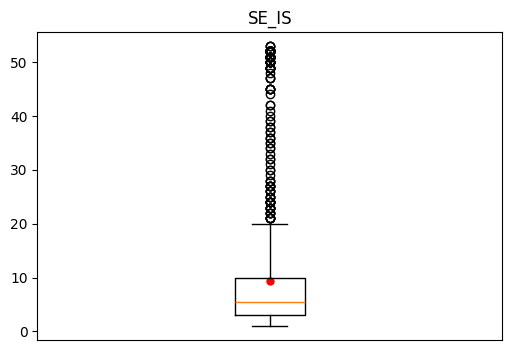

In [27]:
#Excluindo nulos em DataFrame teste para analisar boxplot
df_boxplot = df.dropna(subset=['SE_IS'])

# Plotando o gráfico boxplot
plt.figure(figsize=(6, 4))
plt.boxplot([df_boxplot['SE_IS']])
plt.scatter(1, df_boxplot['SE_IS'].mean(), color='red', marker='o', s=25)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('SE_IS')
plt.show()

Analisando o gráfico, fica evidente que a alta quantidade de outliers está deslocando a média significativamente da região com uma maior densidade de dados. Logo, para este caso, os valores nulos serão substituídos pela mediana.

In [28]:
# Substituindo nulos por mediana
substituir_nulos_por_mediana_coluna(df, 'SE_IS')

print('Valores nulos:', sum(df['SE_IS'].isnull()))

Valores nulos: 0


## MES_IS

A coluna 'MES_IS' é numérica, e o único problema que ela apresenta são seus valores nulos.

In [29]:
print(f"Existem {len(df['MES_IS'].value_counts())} variáveis diferentes e {df['MES_IS'].isnull().sum()} valores nulos.")

Existem 12 variáveis diferentes e 11 valores nulos.


In [30]:
# Ocorrências de meses
t_ocorrencia(df['MES_IS'])

- A variável 1.0 representa 46.60% do total.
- A variável 2.0 representa 22.35% do total.
- A variável 3.0 representa 14.27% do total.
- A variável 4.0 representa 6.63% do total.
- A variável 12.0 representa 5.93% do total.
- A variável 5.0 representa 1.78% do total.
- A variável 6.0 representa 0.91% do total.
- A variável 7.0 representa 0.40% do total.
- A variável 11.0 representa 0.36% do total.
- A variável 9.0 representa 0.33% do total.
[...]


O mês 1 aparece com uma frequência muito alta, logo, faz mais sentido atribuir os valores nulos a ele.

In [31]:
# Transformando valores nulos em 1, que representa o mês de janeiro
df.loc[df['MES_IS'].isna(), 'MES_IS'] = 1.0

print('Valores nulos:', sum(df['MES_IS'].isnull()))

Valores nulos: 0


### 'ANO_IS' e 'MONITORAMENTO_IS'
As colunas 'ANO_IS' e 'MONITORAMENTO_IS' representam objetivamente a mesma coisa, logo, por a coluna 'ANO_IS' já ser numérica, a coluna 'MONITORAMENTO_IS' será excluída.

In [32]:
df = df.drop('MONITORAMENTO_IS', axis=1)

df.head(3)

,UF_LPI,MUN_LPI,IDADE,SE_IS,MES_IS,ANO_IS,OBITO,MACRORREG_LPI_SE,SEXO_M
0,0.147933,0.002175,42.61543,48.0,11.0,1994,SIM,0,1
1,0.147933,0.000363,19.00000,8.0,2.0,1995,NÃO,0,1
2,0.147933,0.000725,32.00000,13.0,4.0,1995,IGN,0,1


### 'OBITO'

Esta é a coluna que se pretende prever, por isso, ela será dividida em duas, as que possuem uma resposta, e as que as respostas foram ignoradas. Por fim, as que possuíram respostas serão usadas para prever com base nas características das outras colunas se o indivíduo morreu ou não.

In [33]:
# DataFrame para treino
df_treino = df[df['OBITO'] != 'IGN']
df_treino = coluna_letras_para_binario(df_treino, 'OBITO')

# DataFrame que se pretende prever
df_predicao = df[df['OBITO'] == 'IGN']
df_predicao = coluna_letras_para_binario(df_predicao, 'OBITO')

### Normalizando colunas

Com os dois DataFrames definidos, agora basta normalizar as colunas para que eles fiquem na mesma escala.

In [34]:
from sklearn.preprocessing import MinMaxScaler

# Inicializa o scaler
scaler = MinMaxScaler()

# Normalizando as colunas do DataFrame
for coluna in df_treino.columns:
    df_treino[coluna] = scaler.fit_transform(df_treino[[coluna]])

    if coluna != 'OBITO_SIM':
        df_predicao[coluna] = scaler.fit_transform(df_predicao[[coluna]])

# Predição

### Testando acurácia para diferentes agrupamentos

Para escolher o melhor modelo de acordo com o melhor agrupamento de dados, serão feitos testes que vão de 2 a 20 grupos para todos os métodos de predição, e o modelo com número de agrupamento que possuir a melhor acurácia será o escolhido.

In [35]:
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import (GradientBoostingClassifier, 
                              BaggingClassifier, 
                              AdaBoostClassifier, 
                              ExtraTreesClassifier, 
                              RandomForestClassifier, 
                              HistGradientBoostingClassifier)

from sklearn.naive_bayes import (BernoulliNB, 
                                 CategoricalNB, 
                                 ComplementNB, 
                                 GaussianNB, 
                                 MultinomialNB)

from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, 
                                           QuadraticDiscriminantAnalysis)

from sklearn.neighbors import (KNeighborsClassifier, 
                               NearestCentroid, 
                               RadiusNeighborsClassifier)

from sklearn.svm import (SVC, 
                         NuSVC, 
                         LinearSVC)

from sklearn.linear_model import (PassiveAggressiveClassifier, 
                                  Perceptron, 
                                  RidgeClassifier, 
                                  RidgeClassifierCV, 
                                  SGDClassifier)

# Separando as variáveis independentes (X) da variável dependente (y)
X = df_treino.drop('OBITO_SIM', axis=1)
y = df_treino['OBITO_SIM']

# Dividindo o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('|Agmts.\t|Melhor Modelo\t\t\t|Acrc.\t|')

for i in range(2,12):

    # Treinando o modelo KMeans apenas com as features de treino
    kmeans = c_kmeans(i, X_train)
    X_train_clusters = kmeans.fit_predict(X_train)

    # Atribuindo os clusters aos dados de teste usando os centroids do modelo treinado
    X_test_clusters = kmeans.predict(X_test)

    # Adicionando as features de cluster ao conjunto de dados de treino e teste
    X_train_clustered = pd.concat([X_train.reset_index(drop=True), pd.get_dummies(X_train_clusters, prefix='cluster')], axis=1)
    X_test_clustered = pd.concat([X_test.reset_index(drop=True), pd.get_dummies(X_test_clusters, prefix='cluster')], axis=1)

    # Treinando e avaliando modelos
    models = {    
        'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
        'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
        'BaggingClassifier': BaggingClassifier(random_state=42),
        'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
        'RandomForestClassifier': RandomForestClassifier(random_state=42),
        'HistGradientBoostingClassifier': HistGradientBoostingClassifier(random_state=42),
        'BernoulliNB': BernoulliNB(),
        'CategoricalNB': CategoricalNB(),
        'ComplementNB': ComplementNB(),
        'GaussianNB': GaussianNB(),
        'MultinomialNB': MultinomialNB(),
        'CalibratedClassifierCV': CalibratedClassifierCV(),
        'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
        'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
        'KNeighborsClassifier': KNeighborsClassifier(),
        'NearestCentroid': NearestCentroid(),
        'RadiusNeighborsClassifier': RadiusNeighborsClassifier(),
        'SVC': SVC(),
        'NuSVC': NuSVC(),
        'LinearSVC': LinearSVC(),
        'GaussianProcessClassifier': GaussianProcessClassifier(),
        'MLPClassifier': MLPClassifier(random_state=42),
        'PassiveAggressiveClassifier': PassiveAggressiveClassifier(random_state=42),
        'Perceptron': Perceptron(random_state=42),
        'RidgeClassifier': RidgeClassifier(random_state=42),
        'RidgeClassifierCV': RidgeClassifierCV(),
        'SGDClassifier': SGDClassifier(random_state=42),
        'DummyClassifier': DummyClassifier(),
    }

    melhor_modelo = ''
    melhor_acuracia = 0.0

    for name, model in models.items():

        # Ignorando avisos        
        warnings.filterwarnings("ignore", category=FutureWarning, message="The SAMME.R algorithm*")
        warnings.filterwarnings("ignore", category=FutureWarning, message="The default value of `dual` will change*")
        warnings.filterwarnings("ignore", category=UserWarning, message="Variables are collinear*")
        warnings.filterwarnings("ignore", category=ConvergenceWarning, message="Stochastic Optimizer: Maximum iterations*")
        
        try:
            model.fit(X_train_clustered, y_train)
            y_pred = model.predict(X_test_clustered)
            accuracy = accuracy_score(y_test, y_pred)

            if accuracy > melhor_acuracia:
                melhor_acuracia = accuracy
                melhor_modelo = name

        except Exception as e:
            pass
        
    print(f'|{i}\t|{melhor_modelo}\t|{melhor_acuracia:.4f}\t|')

|Agmts.	|Melhor Modelo			|Acrc.	|
|2	|HistGradientBoostingClassifier	|0.6729	|
|3	|GradientBoostingClassifier	|0.6667	|
|4	|HistGradientBoostingClassifier	|0.6654	|
|5	|HistGradientBoostingClassifier	|0.6891	|
|6	|HistGradientBoostingClassifier	|0.6754	|
|7	|HistGradientBoostingClassifier	|0.6717	|
|8	|HistGradientBoostingClassifier	|0.6667	|
|9	|GradientBoostingClassifier	|0.6642	|
|10	|RadiusNeighborsClassifier	|0.6679	|
|11	|RadiusNeighborsClassifier	|0.6679	|


### Treinando e realizando Predição

Como pode ser visto, o modelo 'HistGradientBoostingClassifier' com 5 grupos foi o que obteve o melhor resultado, logo, será o utilizado.

In [36]:
# Separando as variáveis independentes (X) da variável dependente (y) do modelo de treino
X_train = df_treino.drop('OBITO_SIM', axis=1)
y_train = df_treino['OBITO_SIM']

# Definindo variáveis independentes (X) do modelo de predição
X_predt = df_predicao

# Treinando o modelo KMeans
kmeans = c_kmeans(5, X_train)
X_train_clusters = kmeans.fit_predict(X_train)
X_predt_clusters = kmeans.fit_predict(X_predt)

# Adicionando as features de cluster ao conjunto de dados de treino e teste
X_train_clustered = pd.concat([X_train.reset_index(drop=True), pd.get_dummies(X_train_clusters, prefix='cluster')], axis=1)
X_predt_clustered = pd.concat([X_predt.reset_index(drop=True), pd.get_dummies(X_predt_clusters, prefix='cluster')], axis=1)

# Treinando modelos
models = {'HistGradientBoostingClassifier': HistGradientBoostingClassifier(random_state=42),}
model.fit(X_train_clustered, y)
y_pred = model.predict(X_predt_clustered)

# Adicionando valores preditos ao DataFrame de predição
df_predicao['OBITO_SIM'] = y_pred

Por fim, basta obter o DataFrame final, com todos os dados prontos.

In [37]:
# Adicionando resultados à coluna 'OBITO'
df_final.loc[df_final.index.intersection(df_treino.index), 'OBITO'] = df_treino['OBITO_SIM']
df_final.loc[df_final.index.intersection(df_predicao.index), 'OBITO'] = df_predicao['OBITO_SIM']

# Convertendo resultados
df_final['OBITO'] = df_final['OBITO'].map({0.0: 'Não', 1.0: 'Sim'})

# Exportando arquivo para .CSV
df_final.to_csv('output.csv', index=False)

df_final

,ID,MACRORREG_LPI,COD_UF_LPI,UF_LPI,COD_MUN_LPI,MUN_LPI,SEXO,IDADE,DT_IS,SE_IS,MES_IS,ANO_IS,MONITORAMENTO_IS,OBITO
0,1,N,14,RR,140005.0,Alto Alegre,M,NaN,29/11/1994,48.0,11.0,1994,1994/1995,Sim
1,2,N,14,RR,140045.0,Pacaraima,M,19,19/02/1995,8.0,2.0,1995,1994/1995,Não
2,3,NE,21,MA,210060.0,Amarante do Maranhão,M,32,01/04/1995,13.0,4.0,1995,1994/1995,Não
3,4,NE,21,MA,210060.0,Amarante do Maranhão,M,33,03/04/1995,14.0,4.0,1995,1994/1995,Sim
4,5,N,15,PA,150270.0,Conceição do Araguaia,M,26,12/04/1995,15.0,4.0,1995,1994/1995,Sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2753,2754,S,42,SC,420060.0,ÁGUAS MORNAS,M,34,19/03/2021,11.0,3.0,2021,2020/2021,Sim
2754,2755,S,42,SC,421780.0,TAIÓ,F,40,06/01/2021,1.0,1.0,2021,2020/2021,Não
2755,2756,N,15,PA,150030.0,AFUÁ,M,18,19/05/2021,20.0,5.0,2021,2020/2021,Não
2756,2757,N,15,PA,150030.0,AFUÁ,M,21,07/07/2021,27.0,7.0,2021,2021/2022,Sim
